# **1. Download data and install packages**

In [1]:
!gdown 1QEbk-ELdmjEpmFcWyYnOQwd0DRr9eL2G

Downloading...
From (original): https://drive.google.com/uc?id=1QEbk-ELdmjEpmFcWyYnOQwd0DRr9eL2G
From (redirected): https://drive.google.com/uc?id=1QEbk-ELdmjEpmFcWyYnOQwd0DRr9eL2G&confirm=t&uuid=f3a3ca54-5ce1-461c-84fe-799b63c7a05f
To: /content/mit_bih_data.csv
100% 765M/765M [00:08<00:00, 88.8MB/s]


In [2]:
!pip -qq install PyWavelets
!pip -qq install pyts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 65.6 MB/s eta 0:00:00


# **2. Importing libraries and data**

In [3]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import pywt # For wavelet transform
from pyts.image import MarkovTransitionField # For Markov Transition Field

In [4]:
# First 271 cols contain data, Last col contains class (5 different classes)
df = pd.read_csv('./mit_bih_data.csv', header=None)
df

,0,1,2,3,4,5,6,7,8,9,...,262,263,264,265,266,267,268,269,270,271
0,0.588844,0.588654,0.588334,0.587855,0.587206,0.586394,0.585464,0.584492,0.583573,0.582812,...,0.581103,0.581080,0.581053,0.581026,0.580996,0.580946,0.580866,0.580745,0.580595,0.0
1,0.578133,0.577636,0.577092,0.576522,0.575956,0.575431,0.574974,0.574603,0.574331,0.574159,...,0.579950,0.579893,0.579956,0.580128,0.580379,0.580662,0.580920,0.581086,0.581096,0.0
2,0.573414,0.572866,0.572233,0.571576,0.570973,0.570499,0.570210,0.570125,0.570227,0.570463,...,0.585479,0.585485,0.585377,0.585168,0.584886,0.584562,0.584228,0.583907,0.583619,0.0
3,0.577282,0.577243,0.577355,0.577547,0.577735,0.577841,0.577800,0.577572,0.577153,0.576572,...,0.581164,0.581510,0.581999,0.582616,0.583305,0.583991,0.584573,0.584963,0.585090,0.0
4,0.576740,0.576704,0.576705,0.576707,0.576683,0.576618,0.576515,0.576386,0.576264,0.576167,...,0.586527,0.586918,0.587336,0.587758,0.588162,0.588520,0.588796,0.588948,0.588941,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112497,0.428762,0.427685,0.426598,0.425531,0.424482,0.423434,0.422382,0.421346,0.420375,0.419542,...,0.426686,0.427223,0.428053,0.429110,0.430266,0.431346,0.432168,0.432584,0.432518,0.0
112498,0.434033,0.434040,0.434087,0.434045,0.433790,0.433248,0.432413,0.431352,0.430186,0.429057,...,0.428152,0.426986,0.426260,0.426087,0.426461,0.427260,0.428275,0.429270,0.430037,0.0
112499,0.433764,0.433542,0.433291,0.432878,0.432264,0.431493,0.430688,0.430014,0.429629,0.429635,...,0.420577,0.421564,0.422542,0.423309,0.423729,0.423750,0.423427,0.422894,0.422332,0.0
112500,0.424160,0.424108,0.423675,0.422888,0.421871,0.420816,0.419940,0.419422,0.419369,0.419788,...,0.424047,0.424681,0.425568,0.426517,0.427351,0.427951,0.428280,0.428385,0.428369,0.0


# **3. Data preprocessing and Train test split**

In [27]:
from sklearn.model_selection import train_test_split

X, y = df.to_numpy()[:,:-1], df.to_numpy()[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

def print_class_distribution(y, name):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    print(f"Class distribution for {name}:")
    for class_label, count in zip(unique_classes, class_counts):
        print(f"Class {class_label}: {count} samples ({count/len(y)*100:.2f}%)")

print_class_distribution(y_train, "y_train")
print()
print_class_distribution(y_test, "y_test")


Class distribution for y_train:
Class 0.0: 72400 samples (80.44%)
Class 1.0: 2251 samples (2.50%)
Class 2.0: 5787 samples (6.43%)
Class 3.0: 623 samples (0.69%)
Class 4.0: 8940 samples (9.93%)

Class distribution for y_test:
Class 0.0: 18149 samples (80.66%)
Class 1.0: 528 samples (2.35%)
Class 2.0: 1447 samples (6.43%)
Class 3.0: 179 samples (0.80%)
Class 4.0: 2198 samples (9.77%)


In [6]:
class MLDataset(Dataset):
    def __init__(self, is_train=True):
      if is_train:
        self.data = X_train
        self.label = y_train
      else:
        self.data = X_test
        self.label = y_test

      ### Wavelet transform
      self.wavelet = "cmor2.5-1.5"
      self.fs = 360  # Sampling frequency from the database

      self.downsampling_data = [sample[::6] for sample in self.data] # Downsampling to 6 times to speed up processing
      self.widths = np.arange(1, self.fs/6+1)[::-1]  # Width for the wavelet transform
      self.wavelet_data = [np.abs(pywt.cwt(sample, self.widths, self.wavelet)[0]) for sample in self.downsampling_data]

      ### Markov Transition field
      self.mtf = MarkovTransitionField(n_bins=16)  # Use 16 different states (bins) to for markov transtion counting
      self.markov_data = [self.mtf.fit_transform(sample.reshape(1, -1))[0] for sample in self.downsampling_data]

    def __getitem__(self, index):
      ### Time data
      time_record_tensor = torch.from_numpy(self.data[index]).float()

      ### Wavelet
      # Expand dims 0 to consider it as a gray image
      wavelet_tensor = torch.from_numpy(np.expand_dims(self.wavelet_data[index], axis=0)).float()

      ### Markov Transition field
      # Expand dims 0 to consider it as a gray image
      markov_tensor = torch.from_numpy(np.expand_dims(self.markov_data[index], axis=0)).float()

      ### Label processing
      # One hot encoding for label
      label_tensor = torch.zeros(5).float() # Initialize a tensor of zeros with length 5 (num_classes=5)
      label_tensor[int(self.label[index])] = 1.0 # Set the element at the index of self.label[index] to 1

      return time_record_tensor, wavelet_tensor, markov_tensor, label_tensor


    def __len__(self):
      return len(self.data)

In [7]:
train_set = MLDataset(is_train=True)

BATCH_SIZE = 256
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/usr/local/lib/python3.11/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/usr/local/lib/python3.11/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/usr/local/lib/python3.11/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equa

In [8]:
# Only run this once when finish training
test_set = MLDataset(is_train=False)

BATCH_SIZE = 256
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE)

/usr/local/lib/python3.11/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "
/usr/local/lib/python3.11/dist-packages/pyts/preprocessing/discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [0]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


In [9]:
# Remove from RAM and GPU memory
# del train_set, train_dataloader
# del test_set, test_dataloader

tensor([1., 0., 0., 0., 0.])


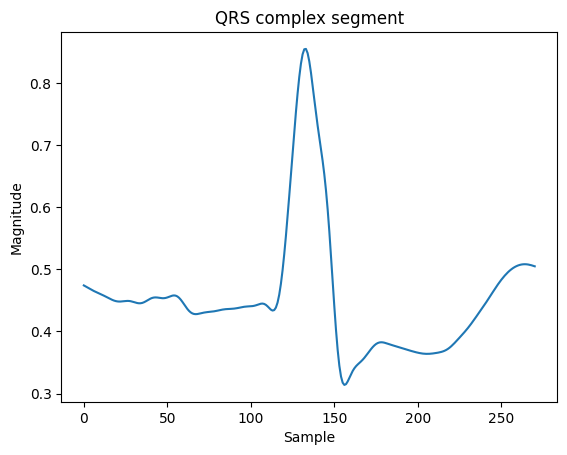

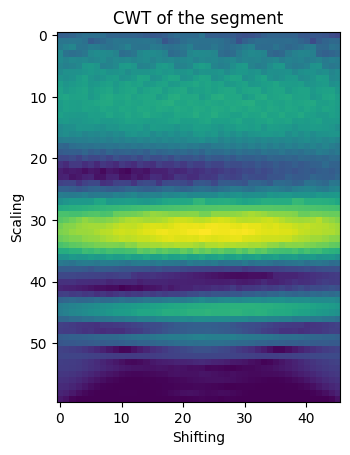

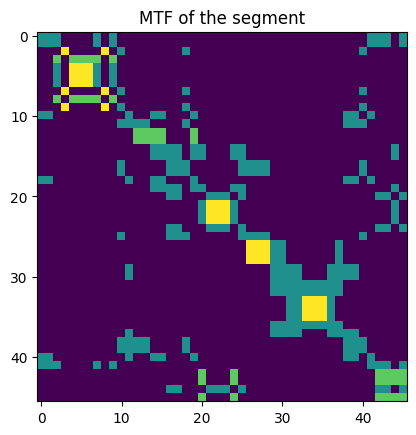

In [10]:
import matplotlib.pyplot as plt

for batch_time_record_tensor, batch_wavelet_tensor, batch_markov_tensor, batch_label_tensor in train_dataloader:
    index = np.random.randint(1, 64)

    print(batch_label_tensor[index])
    plt.plot(batch_time_record_tensor[index])
    plt.title("QRS complex segment")
    plt.xlabel("Sample")
    plt.ylabel("Magnitude")
    plt.show()

    plt.imshow(batch_wavelet_tensor[index][0,:,:])
    plt.title("CWT of the segment")
    plt.xlabel("Shifting")
    plt.ylabel("Scaling")
    plt.show()

    plt.imshow(batch_markov_tensor[index][0,:,:])
    plt.title("MTF of the segment")
    plt.show()
    break

In [11]:
# Dimension check, batch_size = 64, data_length = 271, downsampling_data_length = 91
for batch_time_record_tensor, batch_wavelet_tensor, batch_markov_tensor, batch_label_tensor in train_dataloader:
    print(batch_time_record_tensor.shape)
    print(batch_wavelet_tensor.shape)
    print(batch_markov_tensor.shape)
    print(batch_label_tensor.shape)
    break

torch.Size([256, 271])
torch.Size([256, 1, 60, 46])
torch.Size([256, 1, 46, 46])
torch.Size([256, 5])


# **4. Proposed Learning Model**

In [12]:
# Testing for gpu
device = torch.device('cuda:0')

In [13]:
def conv_block(num_filter):
    dropout_rate = 0.1
    return nn.Sequential(
      nn.Conv2d(in_channels=num_filter, out_channels=num_filter, kernel_size=(1, 1), stride=1, padding=(0, 0)),
      nn.BatchNorm2d(num_features=num_filter),
      nn.Dropout(dropout_rate),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_filter, out_channels=num_filter, kernel_size=(3, 3), stride=1, padding=(1, 1)),
      nn.BatchNorm2d(num_features=num_filter),
      nn.Dropout(dropout_rate),
      nn.ReLU(),
      nn.Conv2d(in_channels=num_filter, out_channels=num_filter*4, kernel_size=(1, 1), stride=1, padding=(0, 0)),
      nn.BatchNorm2d(num_features=num_filter*4),
      nn.Dropout(dropout_rate),
      nn.ReLU(),
    )

class ProposedModel(nn.Module):
  def __init__(self, num_classes):
    super(ProposedModel, self).__init__()

    """
    Time record flow
    """
    self.fully_connected0 = nn.Sequential(
      nn.Linear(in_features=271, out_features=4096),
      nn.BatchNorm1d(num_features=4096),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(in_features=4096, out_features=4096),
      nn.BatchNorm1d(num_features=4096),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(in_features=4096, out_features=num_classes),  # num_classes = 5
      nn.BatchNorm1d(num_features=num_classes),
      nn.Dropout(0.1),
      nn.Softmax(dim=1),
    )
    """
    End of Time record flow
    """


    """
    Wavelet transform flow
    """
    self.block0 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=2, padding=(3, 3)),
      nn.BatchNorm2d(num_features=64),
      nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1)),
    )

    self.block1_filter_size = 64
    self.block1 = conv_block(num_filter=self.block1_filter_size)
    self.block1_projection = nn.Conv2d(in_channels=self.block1_filter_size,
                                       out_channels=self.block1_filter_size*4,
                                       kernel_size=(1, 1), stride=1, padding=(0, 0))

    self.block2_filter_size = 256
    self.block2_downsampling = nn.Conv2d(in_channels=self.block2_filter_size,
                                         out_channels=self.block2_filter_size,
                                         kernel_size=(1, 1), stride=2, padding=(0, 0))

    self.block2 = conv_block(num_filter=self.block2_filter_size)
    self.block2_projection = nn.Conv2d(in_channels=self.block2_filter_size,
                                       out_channels=self.block2_filter_size*4,
                                       kernel_size=(1, 1), stride=2, padding=(0, 0))

    self.fully_connected1 = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=1024*(8*6), out_features=2048),
      nn.BatchNorm1d(num_features=2048),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(in_features=2048, out_features=2048),
      nn.BatchNorm1d(num_features=2048),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(in_features=2048, out_features=num_classes),  # num_classes = 5
      nn.BatchNorm1d(num_features=num_classes),
      nn.Dropout(0.1),
      nn.Softmax(dim=1),
    )
    """
    End of Wavelet transform flow
    """
#
#
    # """
    # Markov Transition Field flow
    # """
    self.block3 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7, 7), stride=2, padding=(3, 3)),
      nn.BatchNorm2d(num_features=64),
      nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=(1, 1)),
    )

    self.block4_filter_size = 64
    self.block4 = conv_block(num_filter=self.block4_filter_size)
    self.block4_projection = nn.Conv2d(in_channels=self.block4_filter_size,
                                       out_channels=self.block4_filter_size*4,
                                       kernel_size=(1, 1), stride=1, padding=(0, 0))

    self.block5_filter_size = 256
    self.block5_downsampling = nn.Conv2d(in_channels=self.block5_filter_size,
                                         out_channels=self.block5_filter_size,
                                         kernel_size=(1, 1), stride=2, padding=(0, 0))
    self.block5 = conv_block(num_filter=self.block5_filter_size)
    self.block5_projection = nn.Conv2d(in_channels=self.block5_filter_size,
                                       out_channels=self.block5_filter_size*4,
                                       kernel_size=(1, 1), stride=2, padding=(0, 0))

    self.fully_connected2 = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=1024*(6*6), out_features=2048),
      nn.BatchNorm1d(num_features=2048),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(in_features=2048, out_features=2048),
      nn.BatchNorm1d(num_features=2048),
      nn.Dropout(0.1),
      nn.ReLU(),
      nn.Linear(in_features=2048, out_features=num_classes),  # num_classes = 5
      nn.BatchNorm1d(num_features=num_classes),
      nn.Dropout(0.1),
      nn.Softmax(dim=1),
    )
    # """
    # End of Markov Transition Field flow
    # """

  def forward(self, time_record_tensor, wavelet_tensor, markov_tensor):
  # def forward(self, wavelet_tensor):
    """
    Dimension reminder
    [64, 271]: batch_time_record_tensor_shape
    [64, 1, 120, 91]: batch_wavelet_tensor_shape
    [64, 1, 91, 91]: batch_markov_tensor_shape
    [64, 5]: batch_label_tensor_shape
    """

    """
    Time record flow
    """
    time_record_flow = self.fully_connected0(time_record_tensor)
    """
    End of Time record flow
    """


    """
    Wavelet flow
    """
    wavelet_flow = self.block0(wavelet_tensor)
#
    # # Block 1
    identity = wavelet_flow
    wavelet_flow = self.block1(wavelet_flow)
    wavelet_flow = wavelet_flow + self.block1_projection(identity)
#
    # # Block 2
    identity = wavelet_flow
    wavelet_flow = self.block2_downsampling(wavelet_flow)
    wavelet_flow = self.block2(wavelet_flow)
    wavelet_flow = wavelet_flow + self.block2_projection(identity)

    wavelet_flow = self.fully_connected1(wavelet_flow)
    """
    End of Wavelet flow
    """
#
#
    # """
    # Markov Transition Field flow
    # """
    markov_flow = self.block3(markov_tensor)

    # Block 4
    identity = markov_flow
    markov_flow = self.block4(markov_flow)
    markov_flow = markov_flow + self.block4_projection(identity)

    # Block 5
    identity = markov_flow
    markov_flow = self.block5_downsampling(markov_flow)
    markov_flow = self.block5(markov_flow)
    markov_flow = markov_flow + self.block5_projection(identity)

    markov_flow = self.fully_connected2(markov_flow)
    """
    End of Markov Transition Field flow
    """

    """
    Merge flows
    """
    final_result = time_record_flow + wavelet_flow + markov_flow
    # final_result = wavelet_flow
    return final_result


from torchsummary import summary

try: # remove previous model when compiling failed
  del model
except:
  pass
model = ProposedModel(num_classes=5).to(device)
# model = ProposedModel(num_classes=5)
# summary(model, input_size=[(271,), (1, 60, 46), (1, 46, 46)])   # dimension debug
# summary(model, input_size=[(1, 46, 46)])

# Test for training model
for epoch in range(1):
  for idx, (time_record_tensor, wavelet_tensor, markov_tensor, label_tensor) in enumerate(train_dataloader):
    # Forward
    time_record_tensor = time_record_tensor.to(device)
    wavelet_tensor = wavelet_tensor.to(device)
    markov_tensor = markov_tensor.to(device)
    label_predict = model(time_record_tensor, wavelet_tensor, markov_tensor).to(device)
    label_tensor = label_tensor.to(device)



    # label_predict = model(time_record_tensor, wavelet_tensor, markov_tensor)


    # label_tensor = label_tensor
    break

In [14]:
# Check model size
model_size = 0
for param in model.parameters():
    if param.data.is_floating_point():
        model_size += param.numel() * torch.finfo(param.data.dtype).bits
    else:
        model_size += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"{model_size / 8e6:.2f} / MB")

820.74 / MB


# **5. Loss function, Optimization Method and Model Training**

In [15]:
### Loss function and Optimization method
from torch import optim

# Loss function
loss_function = nn.CrossEntropyLoss()

# Optimization method
learning_rate = 1e-3
weight_decay = 1e-4  # L2 Regularization
optimizer = optim.Adam(
    params=model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)

In [16]:
del X_train, X_test, y_train, y_test

In [17]:
### Training model
num_epochs = 50
epochs_loss = dict()

for epoch in range(num_epochs):
  # for idx, (time_record_tensor, wavelet_tensor, markov_tensor, label_tensor) in enumerate(train_dataloader):
  for idx, (time_record_tensor, wavelet_tensor, markov_tensor, label_tensor) in enumerate(train_dataloader):
    # Forward
    time_record_tensor = time_record_tensor.to(device)
    wavelet_tensor = wavelet_tensor.to(device)
    markov_tensor = markov_tensor.to(device)
    label_predict = model(time_record_tensor, wavelet_tensor, markov_tensor).to(device)
    label_tensor = label_tensor.to(device)
    # label_predict = model(time_record_tensor, wavelet_tensor, markov_tensor)

    forward_loss = loss_function(label_predict, label_tensor)

    # Backward
    optimizer.zero_grad()
    forward_loss.backward()
    optimizer.step()

  epochs_loss[epoch+1] = forward_loss.item()
  print(f"epoch: {epoch+1}, loss = {forward_loss.item():.4f}")

epoch: 1, loss = 0.6530
epoch: 2, loss = 0.5111
epoch: 3, loss = 0.4273
epoch: 4, loss = 0.3652
epoch: 5, loss = 0.3539
epoch: 6, loss = 0.3153
epoch: 7, loss = 0.3225
epoch: 8, loss = 0.2978
epoch: 9, loss = 0.2740
epoch: 10, loss = 0.2659
epoch: 11, loss = 0.2750
epoch: 12, loss = 0.2526
epoch: 13, loss = 0.2495
epoch: 14, loss = 0.2565
epoch: 15, loss = 0.2513
epoch: 16, loss = 0.2461
epoch: 17, loss = 0.2404
epoch: 18, loss = 0.2458
epoch: 19, loss = 0.2383
epoch: 20, loss = 0.2314
epoch: 21, loss = 0.2258
epoch: 22, loss = 0.2470
epoch: 23, loss = 0.2203
epoch: 24, loss = 0.2373
epoch: 25, loss = 0.2591
epoch: 26, loss = 0.2541
epoch: 27, loss = 0.2295
epoch: 28, loss = 0.2486
epoch: 29, loss = 0.2326
epoch: 30, loss = 0.2300
epoch: 31, loss = 0.2240
epoch: 32, loss = 0.2244
epoch: 33, loss = 0.2486
epoch: 34, loss = 0.2259
epoch: 35, loss = 0.2311
epoch: 36, loss = 0.2251
epoch: 37, loss = 0.2300
epoch: 38, loss = 0.2384
epoch: 39, loss = 0.2211
epoch: 40, loss = 0.2283
epoch: 41

# **6. Model Explain**

In [40]:
import torch
from collections import Counter

# time_record_batch = []
# wavelet_batch = []
# markov_batch = []
# label_batch = []
#
# for idx, (time_record_tensor, wavelet_tensor, markov_tensor, label_tensor) in enumerate(train_dataloader):
#   for time_record in time_record_tensor:
#     time_record_batch.append(time_record)
#
#   for wavelet_record in wavelet_tensor:
#     wavelet_batch.append(wavelet_record)
#
#   for markov_record in markov_tensor:
#     markov_batch.append(markov_record)
#
#   for label_record in label_tensor:
#     label_batch.append(label_record)
#
#
# time_record_batch = torch.stack(time_record_batch).cuda()
# wavelet_batch = torch.stack(wavelet_batch).cuda()
# markov_batch = torch.stack(markov_batch).cuda()
# label_batch = torch.stack(label_batch)

def sample_k_per_class(dataloader, k, num_classes):
    """
    Iterate through dataloader and collect k samples for each class.

    Returns four stacked tensors: (time_recs, wavelets, markovs, labels)
    each of shape (k * num_classes, …).
    """
    collected = Counter()
    buffers = {
        'time':   [],
        'wavelet':[],
        'markov': [],
        'label':  []
    }

    for time_rec, wavelet, markov, label in dataloader:
        # iterate sample-by-sample in the batch
        for tr, wv, mk, lb in zip(time_rec, wavelet, markov, label):
            cls = np.argmax(lb.cpu().detach().numpy())
            if collected[cls] < k:
                buffers['time'].append(tr)
                buffers['wavelet'].append(wv)
                buffers['markov'].append(mk)
                buffers['label'].append(lb)
                collected[cls] += 1

                # stop if every class has k samples
                if len(collected) == num_classes and all(v == k for v in collected.values()):
                    break
        if len(collected) == num_classes and all(v == k for v in collected.values()):
            break

    # sanity check
    total = sum(collected.values())
    if total < k * num_classes:
        raise ValueError(f"Only found {total} samples; "
                         f"needed {k * num_classes} (check your dataset!)")

    # stack into final batches
    time_batch    = torch.stack(buffers['time'])
    wavelet_batch = torch.stack(buffers['wavelet'])
    markov_batch  = torch.stack(buffers['markov'])
    label_batch   = torch.stack(buffers['label'])

    return time_batch, wavelet_batch, markov_batch, label_batch

# ——— Usage ———
k = 2  # number of sample per class
num_classes = 5   # or infer this from your dataset
time_batch, wavelet_batch, markov_batch, label_batch = sample_k_per_class(
    train_dataloader, k, num_classes
)

print(time_batch.shape)    # should be (10, …)
print(wavelet_batch.shape) # (10, …)
print(markov_batch.shape)  # (10, …)
print(label_batch.shape)   # (10,)

torch.Size([10, 271])
torch.Size([10, 1, 60, 46])
torch.Size([10, 1, 46, 46])
torch.Size([10, 5])


In [41]:
import shap

explainer = shap.GradientExplainer(model, [time_batch.cuda(), wavelet_batch.cuda(), markov_batch.cuda()])

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values([time_batch.cuda(), wavelet_batch.cuda(), markov_batch.cuda()])

In [42]:
[np.array(shap_values[i]).shape for i in range(3)]

[(10, 271, 5), (10, 1, 60, 46, 5), (10, 1, 46, 46, 5)]

In [43]:
# prompt: convert shap_values into numpy

import numpy as np
shap_values_0 = np.array(shap_values[0])  # Shap values for feature input 1 (QRS complex)
shap_values_1 = np.array(shap_values[1]).reshape(10, 60, 46, 1, 5) # Shap values for feature input 2 (CWT)
shap_values_2 = np.array(shap_values[2]).reshape(10, 46, 46, 1, 5) # Shap values for feature input 3 (MTF)


In [44]:
# time_features = np.array(time_batch.cpu()).reshape(500, 271)
# wavelet_features = np.array(wavelet_batch.cpu()).reshape(500, 60, 46, 1)
# markov_features = np.array(markov_batch.cpu()).reshape(500, 46, 46, 1)

In [45]:
sample = 1
shap_values_0[sample][:,0:1].shape

(271, 1)

Ground truth class  : 1
Prediction class    : 1
Explain output class: 0
Threshold           : 0.5
Model explains why this is not class 0:
 - P wave     , impact score: -0.0174 => impact: negligible
 - QRS complex, impact score: -0.3929 => impact: moderate negative
 - T wave     , impact score: 0.1592 => impact: weak positive


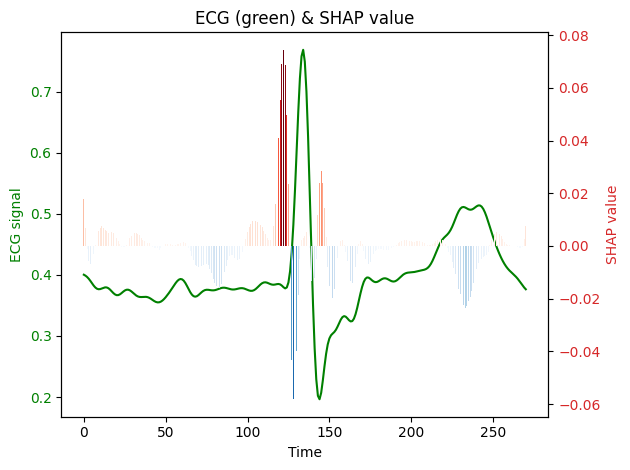





Ground truth class  : 1
Prediction class    : 1
Explain output class: 1
Threshold           : 0.5
Model explains why this is class 1:
 - P wave     , impact score: -0.2310 => impact: weak negative
 - QRS complex, impact score: 0.6178 => impact: strong positive
 - T wave     , impact score: 0.0013 => impact: negligible


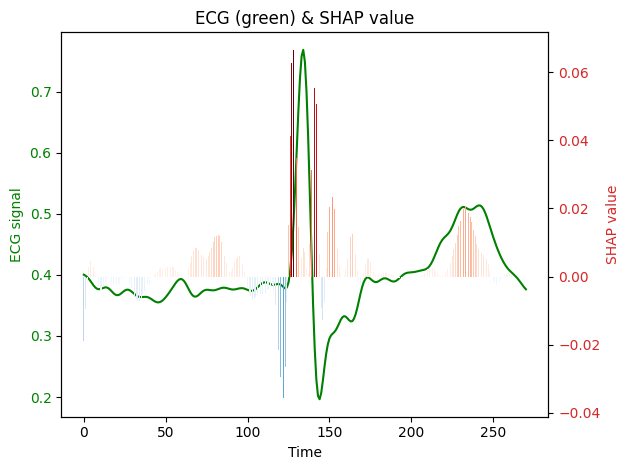





Ground truth class  : 1
Prediction class    : 1
Explain output class: 2
Threshold           : 0.5
Model explains why this is not class 2:
 - P wave     , impact score: -0.2196 => impact: weak negative
 - QRS complex, impact score: 0.8925 => impact: strong positive
 - T wave     , impact score: -0.1092 => impact: negligible


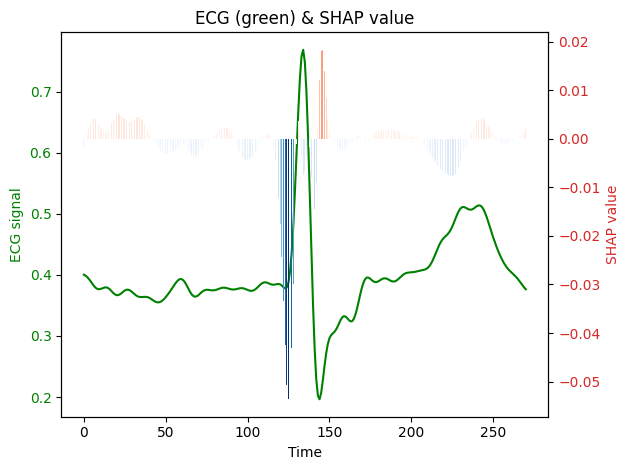





Ground truth class  : 1
Prediction class    : 1
Explain output class: 3
Threshold           : 0.5
Model explains why this is not class 3:
 - P wave     , impact score: 0.0233 => impact: negligible
 - QRS complex, impact score: 0.3253 => impact: moderate positive
 - T wave     , impact score: -0.1404 => impact: weak negative


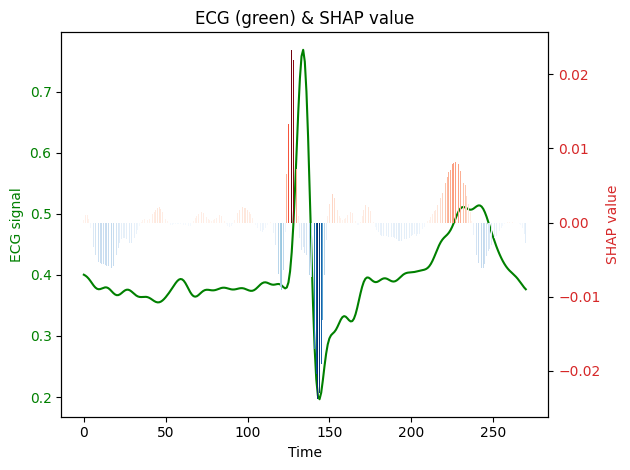





Ground truth class  : 1
Prediction class    : 1
Explain output class: 4
Threshold           : 0.5
Model explains why this is not class 4:
 - P wave     , impact score: -0.2572 => impact: moderate negative
 - QRS complex, impact score: 1.1647 => impact: strong positive
 - T wave     , impact score: -0.1712 => impact: weak negative


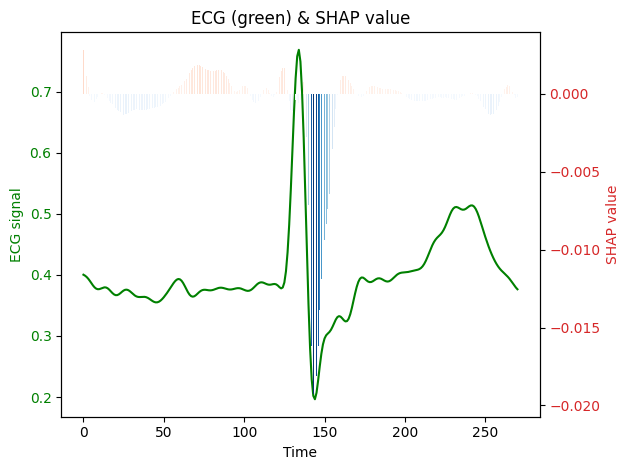

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# ===== User parameters =====
sample = 4                  # ECG sample index
# explain_output = 2        # output to be explained # No need this since we are explain all outputs
fs = 360                    # sampling frequency (Hz)
th = 0.5                    # Threshold to be considered strong impact (0 <= th <= 1)
                            # Can think of total value of SHAP coeffs in this segment
for explain_output in [0, 1, 2, 3, 4]:
  # ===== User parameters =====
  # Uncomment this and delete for loop if want to explain only one output
  # sample = 2                  # ECG sample index
  # # explain_output = 2        # output to be explained
  # fs = 360                    # sampling frequency (Hz)
  # th = 0.2                    # Threshold to be considered strong impact (0 <= th <= 1)
  #                             # Can think of total value of SHAP coeffs in this segment

  # ===== Acquire SHAP values =====
  # shap_values_0: [n_samples, n_timesteps, n_classes]
  shap_val = shap_values_0[sample][:, explain_output]
  max_val = np.max(shap_val)
  min_val = np.min(shap_val)
  # Normalized SHAP values to the range -1 to 1
  # normalized_SHAP_val = 2*(shap_val - min_val)/(max_val - min_val) - 1

  # Standardized SHAP values
  normalized_SHAP_val = (shap_val - np.mean(shap_val)) / np.std(shap_val)

  # ===== Locate R‑peak & define segments =====
  peak_index = np.argmax(time_batch[sample])
  bounds = {
      "P wave     ":      (0,                              peak_index - int(0.06 * fs)),
      "QRS complex": (peak_index - int(0.06 * fs),    peak_index + int(0.06 * fs)),# QRS 0.06-0.1s 0.12s
      "T wave     ":      (peak_index + int(0.06 * fs),    len(normalized_SHAP_val))
  }

  # ===== Classification rule with length normalization =====
  def classify_segment(seg_name, segment, th=0.5, exo_eq_pred=True):
      if not exo_eq_pred:  # When explain output != prediction then the impact will be reverse
          segment = -segment

      impact_score = np.average(segment)
      if impact_score > th:
          return "strong positive", impact_score
      elif impact_score > 0.5 * th:
          return "moderate positive", impact_score
      elif impact_score > 0.25 * th:
          return "weak positive", impact_score
      elif impact_score < -th:
          return "strong negative", impact_score
      elif impact_score < -0.5 * th:
          return "moderate negative", impact_score
      elif impact_score < -0.25 * th:
          return "weak negative", impact_score

      return "negligible", impact_score

  # ===== Prediction, ground truth, and flip flag =====
  prediction = np.argmax(
      model(
          time_batch[sample:sample+1].repeat(256, 1).cuda(),
          wavelet_batch[sample:sample+1].repeat(256, 1, 1, 1).cuda(),
          markov_batch[sample:sample+1].repeat(256, 1, 1, 1).cuda()
      )[0].cpu().detach().numpy()
  )
  ground_truth = np.argmax(label_batch[sample])
  exo_eq_pred = (prediction == explain_output)

  # ===== Build explanations =====
  explanations = {}
  for name, (st, en) in bounds.items():
      segment = normalized_SHAP_val[st:en]
      impact, impact_score = classify_segment(name, segment, th, exo_eq_pred)
      explanations[name] = f"{name}, impact score: {impact_score:.4f} => impact: {impact}"

  # ===== Print outcomes =====
  print(f"Ground truth class  : {ground_truth}")
  print(f"Prediction class    : {prediction}")
  print(f"Explain output class: {explain_output}")
  print(f"Threshold           : {th}")
  print("=============================================")
  comment_label = "" if exo_eq_pred else "not "
  print(f"Model explains why this is {comment_label}class {explain_output}:")
  for seg, txt in explanations.items():
      print(" -", txt)

  # ===== Plot ECG & SHAP =====
  fig, ax1 = plt.subplots()
  ax1.plot(time_batch[sample], color="green")
  ax1.set_xlabel('Time')
  ax1.set_ylabel('ECG signal', color="green")
  ax1.tick_params(axis='y', labelcolor='green')

  ax2 = ax1.twinx()
  ax2.set_ylabel('SHAP value', color='tab:red')
  ax2.tick_params(axis='y', labelcolor='tab:red')
  for i, v in enumerate(shap_val):
      intensity = abs(v) / np.max(np.abs(shap_val))
      color = plt.cm.Reds(intensity) if v > 0 else plt.cm.Blues(intensity)
      ax2.bar(i, v, color=color, width=0.5)

  plt.title(f"ECG (green) & SHAP value")
  fig.tight_layout()
  plt.show()
  print("\n\n\n")

# **7. Saving Model**

In [ ]:
torch.save(model.state_dict(), "ecg_heartbeat_classfication_model")

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_function,
            }, "complete_ecg_heartbeat_classfication_model")